In [1]:
cd C:\\Users\\abelr\\WORK\\GC_JAMES

C:\Users\abelr\WORK\GC_JAMES


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from netCDF4 import Dataset
# from haversine import haversine
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import cmocean as cm
from matplotlib import ticker
import scipy as sp
    
def coarsening(var,fact):
    '''Data will be coarsed by factor fac'''
    assert isinstance(fact, int), type(fact)
    sy, sx = var.shape
    var_out=var.copy()*np.nan
    for i in np.arange(fact,sx+fact,fact):
        for j in np.arange(fact,sy+fact,fact):
            var_out[j-fact:j,i-fact:i]=np.nanmean(var[j-fact:j,i-fact:i].flatten(),0)
    return var_out

def coarsening_all(x1,x2,y1,y2,u,v,fact):
    '''Change in percent relative to not coarsening'''
    U=u[:,y1:y2,x1:x2]
    V=v[:,y1:y2,x1:x2]
    Uc=U.copy()*np.nan
    Vc=Uc.copy()
    t_dim,y_dim,x_dim=U.shape
    for t in np.arange(t_dim):
        Uc[t,:,:]=coarsening(U[t,:,:],fact)
        Vc[t,:,:]=coarsening(V[t,:,:],fact)
    return Uc,Vc

def cmap_discretize(cmap, n_colors):
    """Return a discrete colormap from the continuous colormap cmap.

    Parameters
    ----------
    cmap : str or colormap object
        Colormap to discretize.
    n_colors : int
        Number of discrete colors to divide `cmap` into.

    Returns
    ----------
    discrete_cmap : LinearSegmentedColormap
        Discretized colormap.
    """
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.pyplot as plt

    if type(cmap) == str:
#     if type(cmap) == basestring: # python 2.7
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., n_colors), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., n_colors + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki])
                      for i in range(n_colors + 1)]
    # Return colormap object.
    return LinearSegmentedColormap(cmap.name + "_%d" % n_colors, cdict, 1024)

def drag_coeff(U):
#     rho_a = 1.223
    alpha = 0.00270   # *rho_a
    beta  = 0.000142  # *rho_a
    gamma = 0.0000764 # *rho_a
    Cd = (alpha/U + beta + gamma*U)
    return (Cd)

# References:
# Large, W. G., McWilliams, J. C., & Doney, S. C. (1994). Oceanic vertical mixing: A review and a model with a nonlocal boundary layer parameterization. Reviews of Geophysics, 32(4), 363. http://doi.org/10.1029/94RG01872

g_v   = 2.5 *10**6 #J/kg Gamma_v, latent heat of vaporization
rho_a = 1.223 # kg/m3
c_p   = 1000.5 # J/kg/K
Stef =    5.67e-8 #stefan-boltzmann constant
    
def q_sat(SST): # Saturation humidity
    #temps need to be converted to K
    return 0.98/rho_a*640380*np.exp(-5107.4/(273.15+SST))
    
def C_E(C_D): # Ref: LY2004
    return 34.6* np.sqrt(C_D)/1000

def C_H(C_D,T_diff): # Ref: LY2004
    if np.all(T_diff > 0):
        Ch=18.0* np.sqrt(C_D)/1000 #stable
    else:
        Ch=32.7* np.sqrt(C_D)/1000 #unstable
    return Ch

def tau(U,u):
    return rho_a * drag_coeff(U-u) *np.abs(U - u) * (U - u)

def SH(T_A,SST,U_rel,ice): #negative ocean losses heat
    Cd = drag_coeff(U_rel)
    Ch = C_H(Cd,T_A-SST)
    SH_out = rho_a * c_p * Ch * (T_A - SST) * U_rel
    return SH_out *(1-ice)

def Evap(q,SST,U_rel,ice): 
    Cd = drag_coeff(U_rel)
    Ce = C_E(Cd)
    q_sat_out = q_sat(SST)
    Evap_out = rho_a * Ce * (q - q_sat_out ) * U_rel
    return Evap_out *(1-ice)

def LH(q,q_sat_in,U_rel,ice): #negative ocean losses heat
    Evap_out = Evap(q,q_sat_in,U_rel,ice)
    return g_v * Evap_out

def LW_out(SST,ice): #negative ocean losses heat
    return Stef * (SST+273.15)**4 *(1-ice) * (-1)

In [3]:
x1=0
x2=1440
y1=0
y2=1020

# fpath ='/sfs/fs6/home-geomar/smomw184/_SDIR/ORCA025.L46/ORCA025.L46-KRA024-S/'
# t_data=Dataset(fpath +'ORCA025.L46-KRA024_5d_19940101_19941231_grid_T.nc') #add more years here
t_data=Dataset('ORCA025.L46-KRA024_5d_20010101_20011231_grid_T_time_15.nc') #add more years here
O_sst=t_data.variables['sst_m_inst'][y1:y2,x1:x2].squeeze()
O_t_a=t_data.variables['t_a_inst'][y1:y2,x1:x2].squeeze()-273.15
O_q_a=t_data.variables['q_a_inst'][y1:y2,x1:x2].squeeze()
O_wind_u=t_data.variables['wind_u_rel'][y1:y2,x1:x2].squeeze() # ist INST val
O_wind_v=t_data.variables['wind_v_rel'][y1:y2,x1:x2].squeeze()
O_mld=t_data.variables['somxl010_inst'][y1:y2,x1:x2].squeeze()
O_sic=t_data.variables['soicecov_inst'][y1:y2,x1:x2].squeeze() #sea ice cover
O_lon=t_data.variables['nav_lon'][y1:y2,x1:x2]
O_lat=t_data.variables['nav_lat'][y1:y2,x1:x2]

O_sst[O_sst==0]=np.nan

O_wind = np.sqrt(O_wind_u**2 + O_wind_v**2)

In [4]:
x1=0
x2=384
y1=0
y2=192

# fpath ='/sfs/fs6/home-geomar/smomw184/_SDIR/ORCA025.L46/ORCA025.L46-KRA024-S/'
# t_data=Dataset(fpath +'ORCA025.L46-KRA024_5d_19940101_19941231_grid_T.nc') #add more years here
t_data=Dataset('T127grid_ORCA025.L46-KRA024_5d_20010101_20011231_grid_T_time_15.nc') #add more years here
A_sst=t_data.variables['sst_m_inst'][y1:y2,x1:x2].squeeze()
A_t_a=t_data.variables['t_a_inst'][y1:y2,x1:x2].squeeze()-273.15
A_q_a=t_data.variables['q_a_inst'][y1:y2,x1:x2].squeeze()
A_wind_u=t_data.variables['wind_u_rel'][y1:y2,x1:x2].squeeze() # ist INST val
A_wind_v=t_data.variables['wind_v_rel'][y1:y2,x1:x2].squeeze()
A_mld=t_data.variables['somxl010_inst'][y1:y2,x1:x2].squeeze()
A_sic=t_data.variables['soicecov_inst'][y1:y2,x1:x2].squeeze() #sea ice cover
A_lon=t_data.variables['lon'][:]
A_lat=t_data.variables['lat'][:]

A_lon[A_lon > 180]= A_lon[A_lon > 180]-360

A_lon2, A_lat2=np.meshgrid(A_lon,A_lat)

A_sst[A_sst==0]=np.nan

A_wind = np.sqrt(A_wind_u**2 + A_wind_v**2)

C:\Users\abelr\Anaconda3\lib\site-packages\numpy\ma\core.py:6667: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [5]:
#calculate fluxes
sst=O_sst[:,:]
O_sh=SH(O_t_a[:,:],sst,O_wind[:,:],O_sic[:,:])
O_lh=LH(O_q_a[:,:],sst,O_wind[:,:],O_sic[:,:])
O_lw=LW_out(sst,O_sic[:,:])

sst=A_sst[:,:]
A_sh=SH(A_t_a[:,:],sst,A_wind[:,:],A_sic[:,:])
A_lh=LH(A_q_a[:,:],sst,A_wind[:,:],A_sic[:,:])
A_lw=LW_out(sst,A_sic[:,:])

#interpolate coarse to fine grid
val= (A_sh + A_lh + A_lw)[:,:]
from scipy import interpolate
NN_interp = interpolate.NearestNDInterpolator(np.array([A_lon2.flatten(), A_lat2.flatten()]).T, val.flatten())

coarse_to_fine_fluxes = NN_interp(O_lon.flatten(),O_lat.flatten())
coarse_to_fine_fluxes.shape = O_lon.shape

val= (A_sst)[:,:]
NN_interp = interpolate.NearestNDInterpolator(np.array([A_lon2.flatten(), A_lat2.flatten()]).T, val.flatten())

coarse_to_fine_sst = NN_interp(O_lon.flatten(),O_lat.flatten())
coarse_to_fine_sst.shape = O_lon.shape

C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in greater
C:\Users\abelr\Anaconda3\lib\site-packages\numpy\ma\core.py:1019: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [6]:
#shift latitude so that the center of the boxes is at the point where the grid is defind
# T127 atmosphere and ORCA025 ocean
A_lon2_new= A_lon2-1.875/4
A_lat2_new= A_lat2+1.865/4

O_lon_new= O_lon-0.25/2
O_lat_new= O_lat-0.25/2

thermal_dis=cmap_discretize(cm.cm.thermal,8)
balance_dis=cmap_discretize(cm.cm.balance,12)

C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
C:\Users\abelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


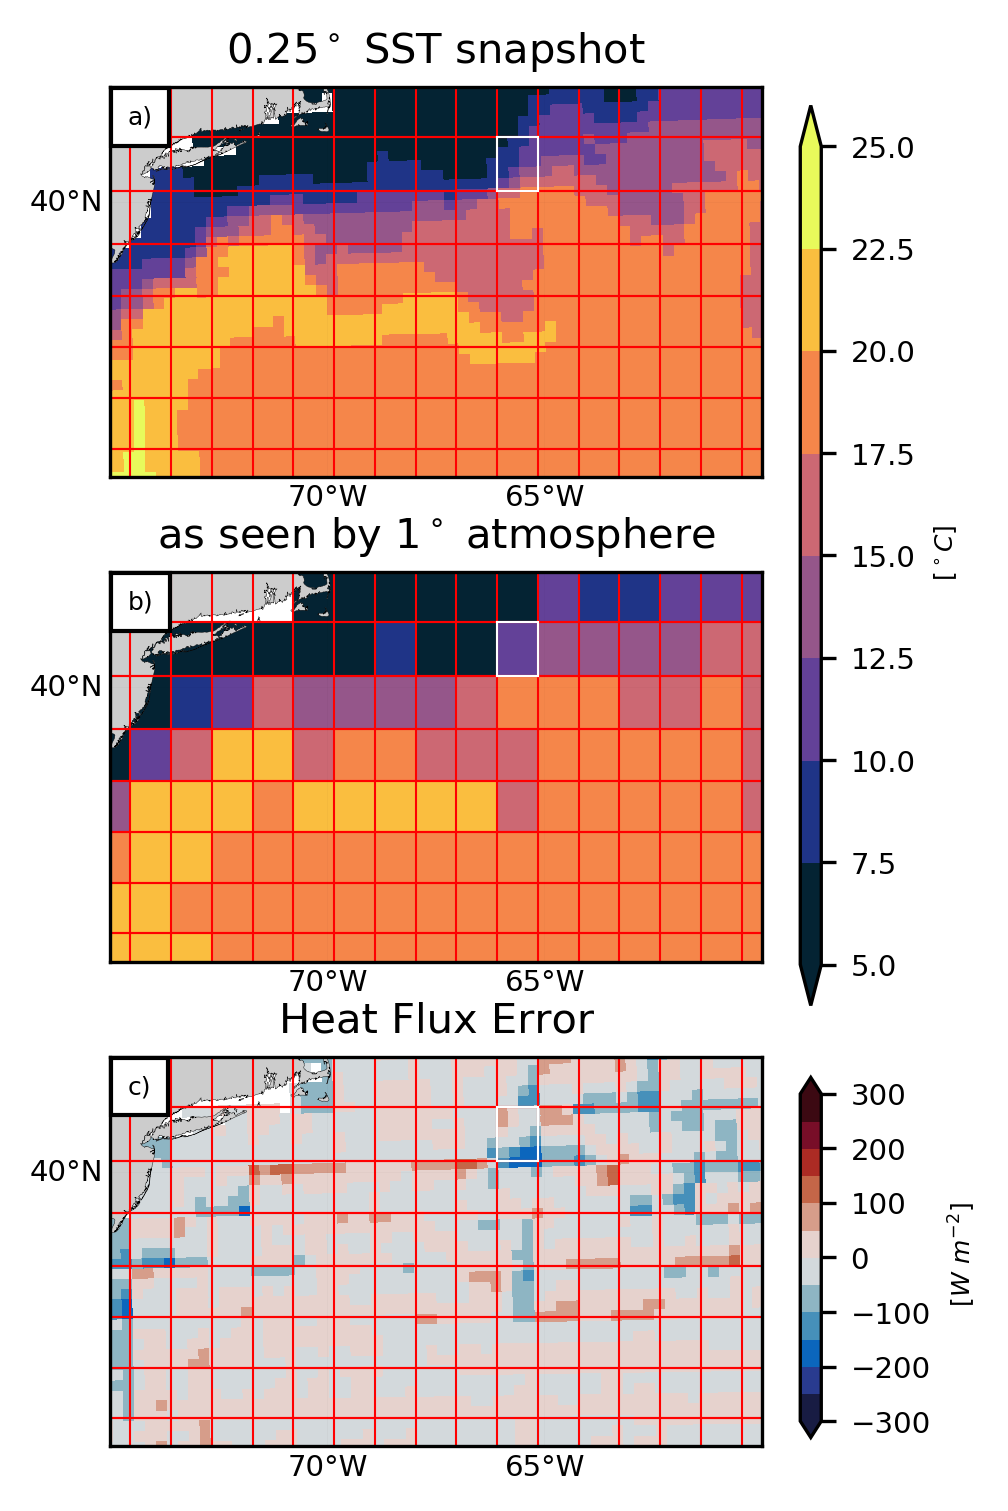

In [7]:
m = Basemap(projection='merc',llcrnrlat=35,urcrnrlat=42,llcrnrlon=-75,urcrnrlon=-60,lat_ts=20,resolution='h')

# white box
i1=-65
i2=-67
j1=40
j2=42
A_lon3_new=A_lon2_new.copy()
A_lat3_new=A_lat2_new.copy()
A_lon3_new[A_lat3_new > j2]=np.nan
A_lon3_new[A_lat3_new < j1]=np.nan
A_lat3_new[A_lat3_new > j2]=np.nan
A_lat3_new[A_lat3_new < j1]=np.nan
A_lon3_new[A_lon3_new > i1]=np.nan
A_lon3_new[A_lon3_new < i2]=np.nan

fig = plt.figure(figsize=(3.5, 6), dpi=300)
gs = gridspec.GridSpec(31, 10)
z_min=5
z_max=25
t=15
                                      #  a)
x1=800
x2=1000
y1=600
y2=800
ax1 = plt.subplot(gs[0:9, 0:9])
cs= m.pcolormesh(O_lon_new[y1:y2,x1:x2],O_lat_new[y1:y2,x1:x2],O_sst[y1:y2,x1:x2],vmin=z_min, vmax=z_max,\
                 cmap=thermal_dis,latlon=True,) #,cmap=co.cm.thermal

xpt,ypt = m(A_lon2_new,A_lat2_new)
for j in np.arange(A_lat2_new.shape[0]):
    plt.plot(xpt[j,:],ypt[j,:],'r',linewidth=0.5)
for i in np.arange(A_lat2_new.shape[1]):
    plt.plot(xpt[:,i],ypt[:,i],'r',linewidth=0.5)

xpt,ypt = m(A_lon3_new,A_lat3_new)
for j in np.arange(A_lat3_new.shape[0]):
    plt.plot(xpt[j,:],ypt[j,:],'-w',linewidth=0.5)
for i in np.arange(A_lat3_new.shape[1]):
    plt.plot(xpt[:,i],ypt[:,i],'-w',linewidth=0.5)
m.drawcoastlines(linewidth=0.1)
m.fillcontinents()
m.drawparallels(np.arange(-50,80,5),labels=[1,0,0,0],linewidth=0.01,fontsize=7)
m.drawmeridians([290,295],labels=[0,0,0,1],linewidth=0.01,fontsize=7)
plt.title('0.25$^\circ$ SST snapshot',fontsize=10)

                                      #  b)
ax2 = plt.subplot(gs[11:20, 0:9])
cs= m.pcolormesh(A_lon2_new,A_lat2_new,A_sst[:,:],vmin=z_min, vmax=z_max,\
                 cmap=thermal_dis,latlon=True) #,cmap=co.cm.thermal

xpt,ypt = m(A_lon2_new,A_lat2_new)
for j in np.arange(A_lat2_new.shape[0]):
    plt.plot(xpt[j,:],ypt[j,:],'r',linewidth=0.5)
for i in np.arange(A_lat2_new.shape[1]):
    plt.plot(xpt[:,i],ypt[:,i],'r',linewidth=0.5)

xpt,ypt = m(A_lon3_new,A_lat3_new)
for j in np.arange(A_lat3_new.shape[0]):
    plt.plot(xpt[j,:],ypt[j,:],'-w',linewidth=0.5)
for i in np.arange(A_lat3_new.shape[1]):
    plt.plot(xpt[:,i],ypt[:,i],'-w',linewidth=0.5)

# plt.colorbar()
m.drawcoastlines(linewidth=0.1)
m.fillcontinents()
m.drawparallels(np.arange(-50,80,5),labels=[1,0,0,0],linewidth=0.01,fontsize=7)
m.drawmeridians([290,295],labels=[0,0,0,1],linewidth=0.01,fontsize=7)
plt.title(r'as seen by 1$^\circ$ atmosphere',fontsize=10)

# cbaxes = fig.add_axes([0.16, 0.53, 0.70, 0.025])
cbaxes = fig.add_axes([0.82, 0.37, 0.02, 0.5])

cb = plt.colorbar(cs,cax = cbaxes,orientation="vertical",extend='both')
cb.ax.tick_params(labelsize=7)
cb.ax.set_ylabel(r' [$^\circ C$]',fontsize=6,rotation=90)

                                      #  c)
ax3 = plt.subplot(gs[22:31, 0:9])
z_min = -300
z_max =  300
var = (O_sh + O_lh + O_lw)[:-1,1:-1]-coarse_to_fine_fluxes[:,:]
# var = coarse_to_fine_sst
# cs= m.pcolormesh(O_lon_new,O_lat_new,var,vmin=z_min, vmax=z_max,cmap=thermal_dis,latlon=True) #,cmap=co.cm.thermal

cs= m.pcolormesh(O_lon_new[y1:y2,x1:x2],O_lat_new[y1:y2,x1:x2],var[y1:y2,x1:x2],vmin=z_min, vmax=z_max,\
                 cmap=balance_dis,latlon=True)
# cs= m.pcolormesh(O_lon_new,O_lat_new,var,vmin=z_min, vmax=z_max,cmap=balance_dis,latlon=True) #,cmap=co.cm.thermal

xpt,ypt = m(A_lon2_new,A_lat2_new)
for j in np.arange(A_lat2_new.shape[0]):
    plt.plot(xpt[j,:],ypt[j,:],'r',linewidth=0.5)
for i in np.arange(A_lat2_new.shape[1]):
    plt.plot(xpt[:,i],ypt[:,i],'r',linewidth=0.5)

xpt,ypt = m(A_lon3_new,A_lat3_new)
for j in np.arange(A_lat3_new.shape[0]):
    plt.plot(xpt[j,:],ypt[j,:],'-w',linewidth=0.5)
for i in np.arange(A_lat3_new.shape[1]):
    plt.plot(xpt[:,i],ypt[:,i],'-w',linewidth=0.5)

# plt.colorbar()
m.drawcoastlines(linewidth=0.1)
m.fillcontinents()
m.drawparallels(np.arange(-50,80,5),labels=[1,0,0,0],linewidth=0.01,fontsize=7)
m.drawmeridians([290,295],labels=[0,0,0,1],linewidth=0.01,fontsize=7)
plt.title('Heat Flux Error',fontsize=10)

# cbaxes = fig.add_axes([0.16, 0.53, 0.70, 0.025])
cbaxes = fig.add_axes([0.82, 0.13, 0.02, 0.20])

cb = plt.colorbar(cs,cax = cbaxes,orientation="vertical",extend='both')
cb.ax.tick_params(labelsize=7)
cb.ax.set_ylabel(r' [$W$ $m^{-2}$]',fontsize=6,rotation=90) #,y=+0.5,labelpad=+10

i=0.027
j=0.924
plt.text(i,j,'a)',    ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=6)
plt.text(i,j,'b)',    ha='left',va='center',transform=ax2.transAxes,bbox={'facecolor':'white'},fontsize=6)
plt.text(i,j,'c)',    ha='left',va='center',transform=ax3.transAxes,bbox={'facecolor':'white'},fontsize=6)

plt.savefig('fig1_SST_error',dpi=300)

In [8]:
!conda list

# packages in environment at C:\Users\abelr\Anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py36_0  
_tflow_select             2.2.0                     eigen  
absl-py                   0.6.1                    py36_0  
alabaster                 0.7.12                   py36_0  
anaconda                  custom           py36h363777c_0  
anaconda-client           1.7.2                    py36_0  
anaconda-navigator        1.9.6                    py36_0  
anaconda-project          0.8.2                    py36_0  
asn1crypto                0.24.0                   py36_0  
astor                     0.7.1                    py36_0  
astroid                   2.1.0                    py36_0  
astropy                   3.1              py36he774522_0  
atomicwrites              1.2.1                    py36_0  
attrs                     18.2.0           py36h28b3542_0  
babel                     2.6.0     

In [9]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: win-64
@EXPLICIT
https://repo.anaconda.com/pkgs/main/win-64/_tflow_select-2.2.0-eigen.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/blas-1.0-mkl.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/ca-certificates-2018.03.07-0.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/conda-env-2.6.0-1.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/icc_rt-2019.0.0-h0cc432a_1.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/intel-openmp-2019.1-144.tar.bz2
https://repo.anaconda.com/pkgs/msys2/win-64/msys2-conda-epoch-20160418-1.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/pandoc-2.2.3.2-0.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/vs2015_runtime-14.15.26706-h3a45250_0.tar.bz2
https://repo.anaconda.com/pkgs/main/win-64/winpty-0.4.3-4.tar.bz2
https://repo.anaconda.com/pkgs/msys2/win-64/m2w64-gmp-6.1.0-2.tar.bz2
https://repo.anaconda.com/pkgs/msys2/win-64/m2w64